# Spectral Clustering

Author: REGUEIRO ESPIÑO Ramón Daniel

email: ramon.regueiro_espino@ens-paris-saclay.fr

Discussion with: GARCÍA PASCUAL, Mario, GARELLA, Guillermo and PEREYRA, Diego.

In this exercise, you will implement spectral clustering and try it on diffent kinds of data, for instance:

* N-blob: Random points in $\mathbb{R}^2$ according to N Gaussian distributions with different means;

* Two moons: Random points shaped as two intertwined moons; 

* Point and circle: random points from a concentrated Gaussian point in the middle and a wide circle around it.

The first step after generating the data is to construct a graph and, for that, we need a similarity function. In this exercise we will use the following similarity:

$$
d(x_i, x_j) = \exp\left(-\frac{||x_i-x_j||_2^2}{2\sigma^2}\right)
$$

Using this similarity, we can compute the weight matrix W representing the graph, compute the graph Laplacian L and finally use its eigenvectors for clustering.



## Setup

In [1]:
from generate_data import worst_case_blob, blobs, two_moons, point_and_circle
from utils import plot_clusters, min_span_tree, plot_graph_matrix, min_span_tree
from utils import plot_clustering_result, plot_the_bend
from sklearn.cluster import KMeans
import sklearn.metrics as skm
import numpy as np
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import os

# networkx 2.8.8 version

/Users/ramondanielregueiroespino/opt/anaconda3/lib/python3.8/site-packages/skimage/io/manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


## Generating the data

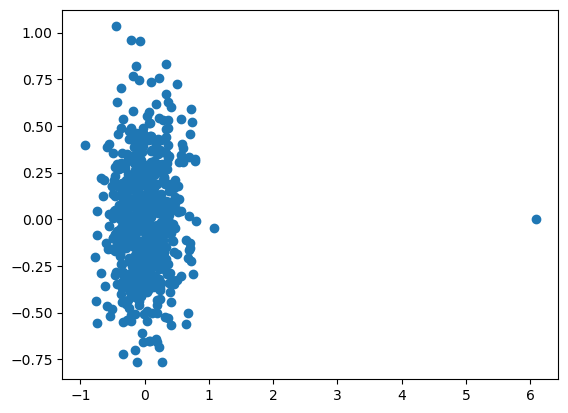

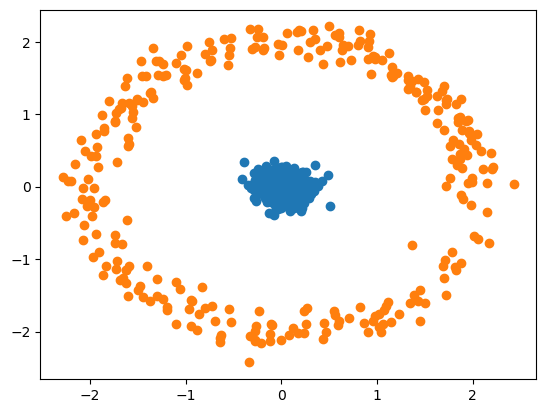

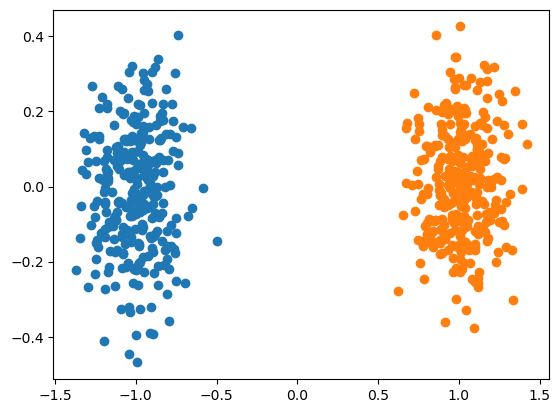

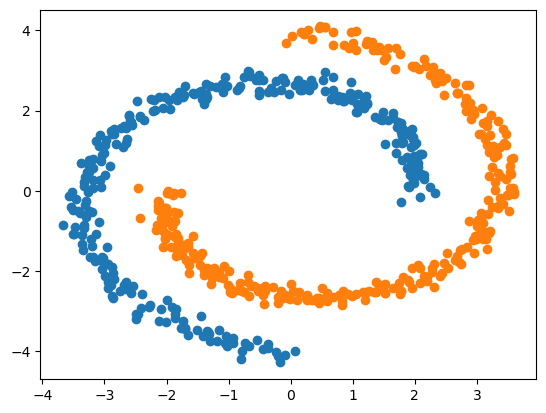

In [2]:
# Example

for fn in [worst_case_blob]:
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
for fn in [point_and_circle]:
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
for fn in [blobs]:
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
for fn in [two_moons]:  #  try also [worst_case_blob, point_and_circle, blobs]
    X, Y = fn(num_samples=600)
    plot_clusters(X, Y, fignum=str(fn))
    
# You can check the documentation of each function to see the optional parameters, e.g.:
#worst_case_blob?

## Building similarity graph

In [3]:
def build_similarity_graph(X, var=1.0, eps=0.0, k=0,method='and'):
    """
    Computes the similarity matrix for a given dataset of samples. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    eps : double
        threshold for epsilon graphs
    k : int
        The number of neighbours k for k-nn. If zero, use epsilon-graph
        
    method: method to build the undirected graph on the k-NN graph
             'and':  and, both edges in the directed k-NN
             'or': or, at least one edge in the directed k-NN

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    n = X.shape[0]
    W = np.zeros((n, n))

    """
    Build similarity graph, before threshold or kNN
    similarities: (n x n) matrix with similarities between all possible couples of points.
    The similarity function is d(x,y)=exp(-||x-y||^2/(2*var))
    """
    def similarity_function(x_i,x_j,var):
        w_ij=np.exp(-np.linalg.norm(x_i-x_j)**2/(2*var))
        return w_ij
  
    similarities = np.zeros((n, n))
    for i in range(n): # we use this structure in case we want to use a non-symmetric function
        for j in range(i,n):
            aux=similarity_function(X[i],X[j],var)
            similarities[i][j]=aux
            similarities[j][i]=aux

    # If epsilon graph
    if k == 0:
        """
        compute an epsilon graph from the similarities             
        for each node x_i, an epsilon graph has weights             
        w_ij = d(x_i,x_j) when w_ij >= eps, and 0 otherwise          
        """
        W = np.zeros((n, n))
        for i in range(n-1): # as it is 
            for j in range(i+1,n):
                # we consider W[i][i]=0 (as asked if it is good to the TA)
                if similarities[i][j]>=eps:
                    W[i][j]=similarities[i][j]
                    W[j][i]=similarities[j][i]

    # If kNN graph
    elif k != 0:
        """
        compute a k-nn graph from the similarities                   
        for each node x_i, a k-nn graph has weights                  
        w_ij = d(x_i,x_j) for the k closest nodes to x_i, and 0     
        for all the k-n remaining nodes                              
        Remember to remove self similarity and                       
        make the graph undirected                                    
        """
        W = np.zeros((n, n))
        for i in range(n):
            sim_i=[similarities[i][j] for j in range(n)]
            similarities_idx=list(np.argsort(sim_i))
            similarities_idx.remove(i)
            similarities_idx.reverse()
            for j in range(k):
                W[i][similarities_idx[j]]=similarities[i][similarities_idx[j]]
        for i in range(n):
            for j in range(1,n):
                if method=='and':
                    if W[i][j]==0 or W[j][i]==0:
                        W[i][j]=0
                        W[j][i]=0
                if method=='or':
                    if W[i][j]==0 and W[j][i]==0:
                        W[i][j]=0
                        W[j][i]=0

    return W


Example of epsilon-graph with epsilon=0.5


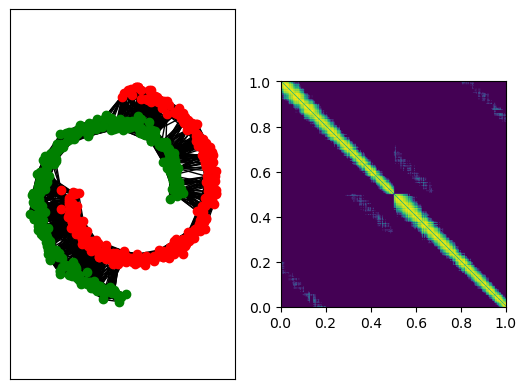

Example of k-NNN graph for 25 neighbors with and


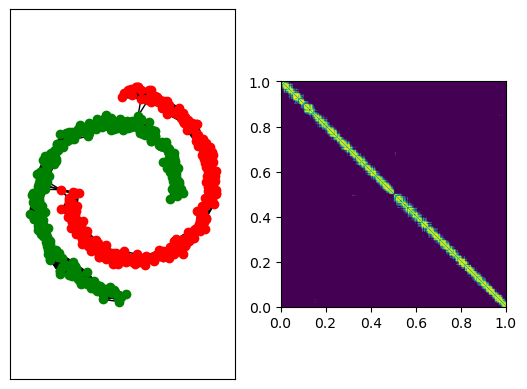

Example of k-NNN graph for 25 neighbors with or


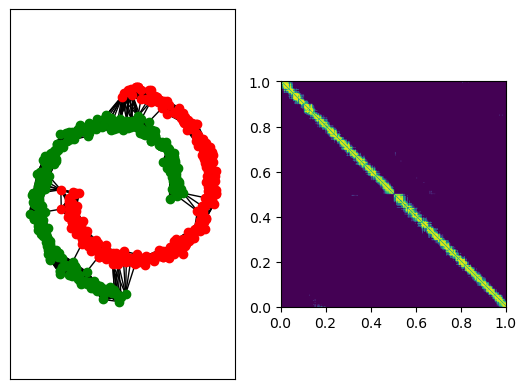

In [4]:
# Example
eps=0.5
print('Example of epsilon-graph with epsilon='+str(eps))
W_k_0 = build_similarity_graph(X,eps=eps)
plot_graph_matrix(X, Y, W_k_0)

k=25
print('Example of k-NNN graph for '+str(25)+ ' neighbors with and')
W_k_25_and = build_similarity_graph(X,k=k,method='and')
plot_graph_matrix(X, Y, W_k_25_and)  # shows the graph and the visualization of W

print('Example of k-NNN graph for '+str(25)+ ' neighbors with or')
W_k_25_or = build_similarity_graph(X,k=k,method='or')
plot_graph_matrix(X, Y, W_k_25_or)


## Computing the Laplacian

In [5]:
def build_laplacian(W, laplacian_normalization='unn'):
    """
    Compute graph Laplacian.

    Parameters
    ----------
    W : numpy array
        Adjacency matrix (n x n)
    laplacian_normalization : str
        String selecting which version of the laplacian matrix to construct.
            'unn':  unnormalized,
            'sym': symmetric normalization
            'rw':  random-walk normalization   

    Returns
    -------
    L: (n x n) dimensional matrix representing the Laplacian of the graph
    """
    L=np.zeros(W.shape)
    
    D=np.diag(np.sum(W,axis=1))
    
    if laplacian_normalization=='unn':
        L=D-W
        
    elif laplacian_normalization=='sym':
        D_inv=np.linalg.inv(D)
        L=np.eye(W.shape[0])-np.dot(np.dot(np.sqrt(D_inv),W),np.sqrt(D_inv))         
        
    elif laplacian_normalization=='rw':
        L=D-W
        D_inv=np.linalg.inv(D)
        L=np.dot(D_inv,L)
        
    return L

## Clustering

In [6]:
def spectral_clustering(L, chosen_eig_indices=None, num_classes=2):
    """
    Perform spectral clustering for the given laplacian by considering known the number of classes.
    Parameters
    ----------
    L : numpy array
        Graph Laplacian (standard or normalized)
    choosen_eig_indices : list or None
        Indices of eigenvectors to use for clustering. 
        If None, use adaptive choice of eigenvectors.
    num_classes : int 
        Number of clusters to compute (defaults to 2)


    Returns
    -------
    Y : numpy array (num_samples, )
        Cluster assignments
    """

    """
    Use the function scipy.linalg.eig or the function scipy.sparse.linalg.eigs to compute:
    U = (n x n) eigenvector matrix           (sorted)
    E = (n x n) eigenvalue diagonal matrix   (sorted)
    """
    import scipy as sp

    def select_eig_indices(eig_val,num_classes):
        """
        Automaticaly choose the eigenvalues indices for clustering.
        Parameters
        ----------
        eig_val: eigenvalues (sorted)
        k: number of clusters
        
        Returns
        -------
        chosen_idx: index of the sorted eigenvalues to use
        """
        chosen_idx = [1]
        suma_total=eig_val[0]+eig_val[1]
        for it in range(2,len(eig_val)):
            suma_total+=eig_val[it]
            if suma_total<0.1:
                chosen_idx.append(it)
            else:
                return chosen_idx
    
    eig_val,eig_vec_right=sp.linalg.eig(L)
    eig_val_idx=list(np.argsort(eig_val))
    eig_val=eig_val.real
    eig_val=eig_val[eig_val_idx]
    
    if chosen_eig_indices==None :
        chosen_idx=select_eig_indices(eig_val,num_classes)
        chosen_eig_indices=chosen_idx
    U=eig_vec_right[:,eig_val_idx]
    U = U[:,chosen_eig_indices].real
    E = np.diag(eig_val)

    
    """
    compute the clustering assignment from the eigenvectors        
    Y = (n x 1) cluster assignments in [0,1,...,num_classes-1]                   
    """
    
    Y = np.zeros(L.shape[0])
    kmeans= KMeans(n_clusters=num_classes)
    kmeans=kmeans.fit(U)
    Y=kmeans.predict(U)
    return Y

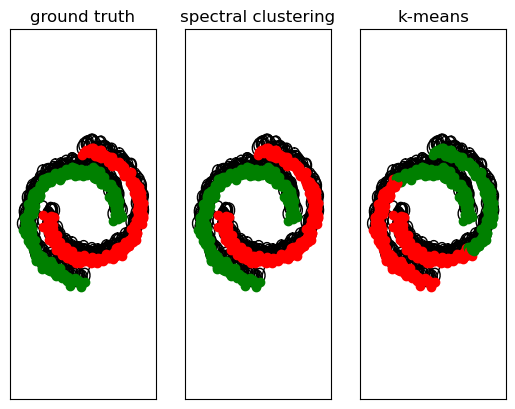

In [7]:
# Example
num_classes = 2

W = build_similarity_graph(X,k=20,method='or')
L = build_laplacian(W)
Y_rec = spectral_clustering(L, chosen_eig_indices=[1,2], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

## Parameter sensitivity 

In [8]:
def parameter_sensitivity(parameter_type='eps'):
    """
    A function to test spectral clustering sensitivity to parameter choice.
    
    parameter_type : str
        String selecting which parameter to use for testing sensitivity.
            'eps':  epsilon (by default),
            'k': number of neighbors.
    """
    # the number of samples to generate
    num_samples = 500

    """
    Choose parameters
    """
    var = 1.0  # exponential_euclidean's sigma^2
    laplacian_normalization='unn'
    chosen_eig_indices = [1,2]

    """
    Choose candidate parameters
    """
    #parameter_type = 'eps' # choose between 'k' or 'eps'
    
    if parameter_type=='eps':
        parameter_candidate=list(np.linspace(0,1,20,endpoint=True))
        k=0
    else:
        parameter_candidate=list(np.arange(10,450,25))
        eps=0.0
        
    parameter_performance = []
    parameter_performance_2=[]

    for parameter in parameter_candidate:
        # Generate data
        X, Y = two_moons(num_samples, 1, 0.02)
        num_classes = len(np.unique(Y))
        
        parameter_wrap = {parameter_type: parameter}
        if parameter_type=='eps':
            eps=parameter
        else:
            k=parameter
        
        W=build_similarity_graph(X, var=var, eps=eps, k=k,method='or')
        L = build_laplacian(W, laplacian_normalization)

        Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

        parameter_performance += [skm.adjusted_rand_score(Y, Y_rec)]
        
        if parameter_type!='eps':
            W=build_similarity_graph(X, var=var, eps=eps, k=k,method='or')
            L = build_laplacian(W, laplacian_normalization)

            Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes)

            parameter_performance_2 += [skm.adjusted_rand_score(Y, Y_rec)]
        
        

    if parameter_type=='eps':
        plt.figure()
        plt.plot(parameter_candidate, parameter_performance)
        plt.title(f'parameter sensitivity ({parameter_type})')
        plt.show()
    else:
        plt.figure()
        plt.plot(parameter_candidate, parameter_performance,c='red',label="or")
        plt.plot(parameter_candidate, parameter_performance_2,c="blue",label="and")
        plt.legend()
        plt.title(f'parameter sensitivity ({parameter_type})')
        plt.show()
    
            

## Image segmentation

In [9]:
def image_segmentation(input_img='four_elements.bmp',k=20,eps=0.0,num_classes = 5,laplacian_normalization = 'unn',chosen_eig_indices=None):
    """
    Function to perform image segmentation.

    :param input_img: name of the image file in /data (e.g. 'four_elements.bmp' or 'fruit_salad.bmp')
    """
    filename = os.path.join('data', input_img)

    X = io.imread(filename)
    X = (X - np.min(X)) / (np.max(X) - np.min(X))

    im_side = np.size(X, 1)
    Xr = X.reshape(im_side ** 2, 3)
    """
    Y_rec should contain an index from 0 to c-1 where c is the     
     number of segments you want to split the image into          
    """

    """
    Choose parameters
    """
    var = 1.0
    
    W = build_similarity_graph(Xr, var=var, k=k,eps=eps,method='or')
    L = build_laplacian(W, laplacian_normalization)
    Y_rec = spectral_clustering(L, chosen_eig_indices, num_classes=num_classes)

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(X)

    plt.subplot(1, 2, 2)
    Y_rec = Y_rec.reshape(im_side, im_side)
    plt.imshow(Y_rec)

    plt.show()

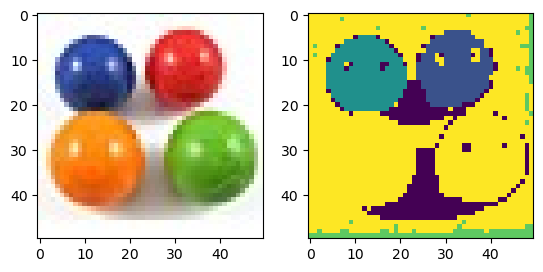

In [10]:
image_segmentation()

# Questions

### Q1.1: What is the purpose of the option parameter in `worst_case_blob`?

Case for delta: 0


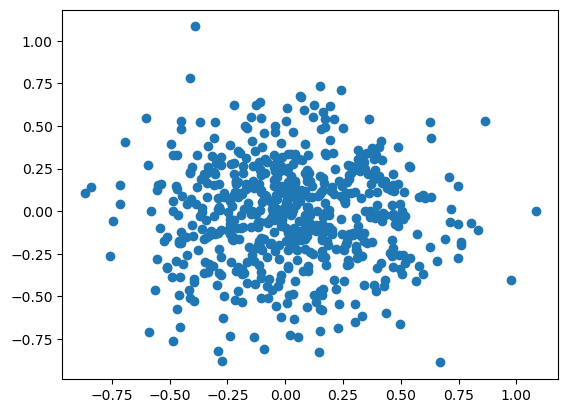

Case for delta: 1


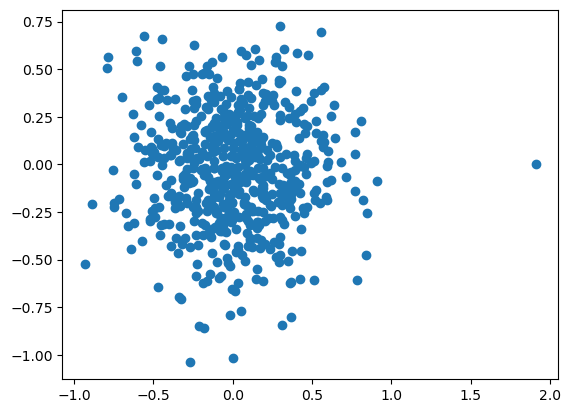

Case for delta: 3


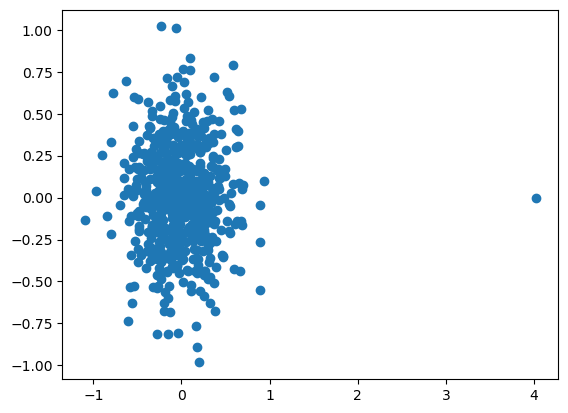

In [11]:
delta_list=[0,1,3]
for val in delta_list:
    for fn in [worst_case_blob]:
        print('Case for delta:',val)
        X, Y = fn(num_samples=600,delta=val)
        plot_clusters(X, Y, fignum=str(fn),show=True)

The purpose of the parameter is to indicate a lower bound of the distance of the outlier point to the other points of the blob. Concretely, the aim of the function _worst_case_blob_ is to create a single blob with one sample that can be far from the others. For this, this extra sample has as second coordinate zero and first coordinate as the maximum of this coordinate for the other samples adding a delta. So, this point will be have at least distance delta to any other point on the sample. We remark that if the distance is zero we cannot distinguish the added point from the others in the blob.

### Q1.2: While varying the parameter of `worst_case_blob`, try to select a value of $\epsilon$ that keeps the graph connected (the function `min_span_tree` can help you). What happens? Can you tell when it is a bad idea to use this approach?

----------delta=0----------
maximum epsilon: 0.9727225213326763


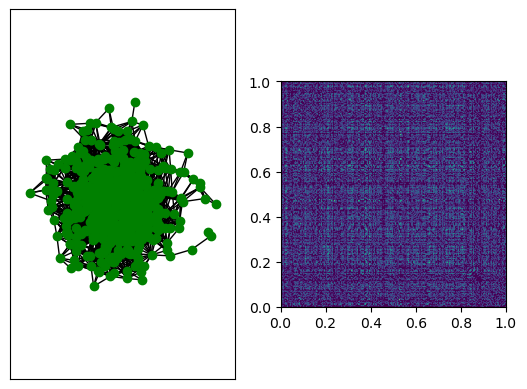

----------delta=1----------
maximum epsilon: 0.583753594177068


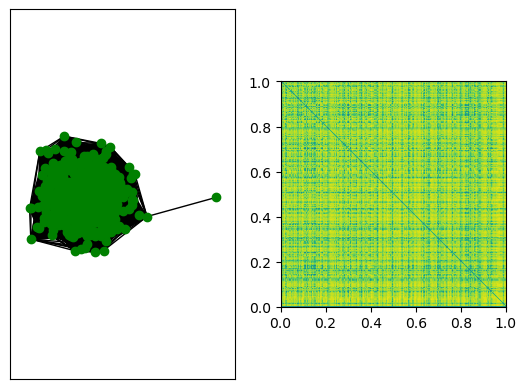

----------delta=3----------
maximum epsilon: 0.011099661196921226


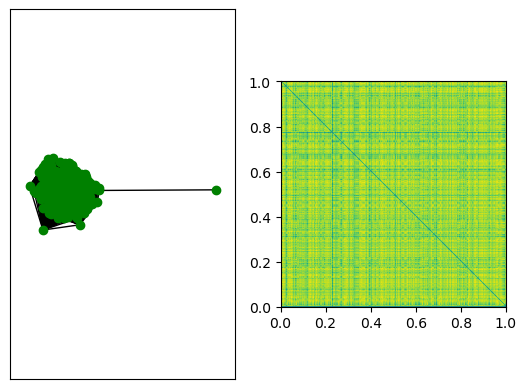

----------delta=5----------
maximum epsilon: 3.7207067132646905e-06


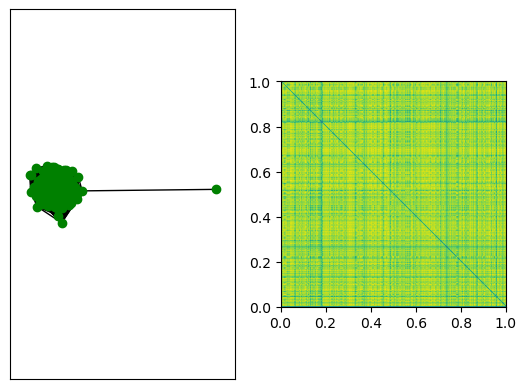

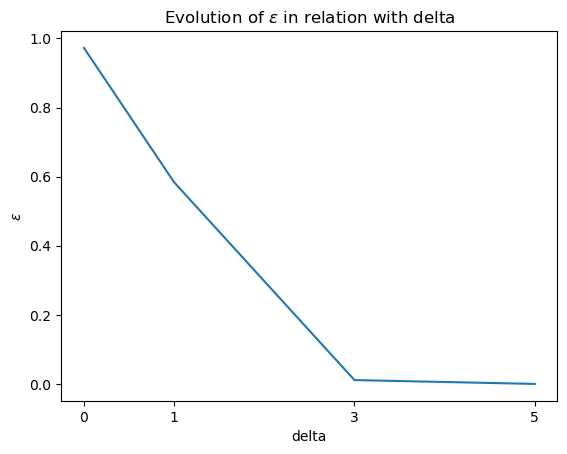

In [12]:
delta_list=[0,1,3,5]
eps_val=[]
for val in delta_list:
    for fn in [worst_case_blob]:
        print('----------delta='+str(val)+'----------')
        X, Y = fn(num_samples=600,delta=val)
        # Connected as eps=0.0
        W=build_similarity_graph(X,var=1.0,eps=0.0,k=0)
        T=min_span_tree(-W)
        min_eps=np.min(W[T>0])
        print('maximum epsilon:',min_eps)
        eps_val.append(min_eps)
        W_new=build_similarity_graph(X,var=1.0,eps=min_eps,k=0)
        plot_graph_matrix(X,Y,W_new)

plt.figure()
plt.plot(delta_list,eps_val)
plt.title(r'Evolution of $\epsilon$ in relation with delta')
plt.xlabel(r'delta')
plt.ylabel(r'$\epsilon$')
plt.xticks(delta_list)
plt.show()

We consider the parameter delta as 0, 1, 3 and 5. After, we generate the data and we apply the function _min_span_tree_ to the opposite of the similarities matrix. This function returns the maximum value of epsilon that can be used to obtain a connected graph. Although, as it can be seen in the figures, if delta is big there exists a node that is far away from others. Then, the maximum epsilon that keeps the graph connected will be small.

A problem created by having a small epsilon and a group of points very close is that they will form a clique. In the considered case, we obtain that there exists a subgraph of the number of samples minus one that is almost a fully connected graph. Also, this can be seen in the figures of the right, where the number of zeros decreases when we increase delta.

### Q1.3: Is it important to build a connected graph? Compare k-NN to $\epsilon$-graphs with respect to the difficulty of building a connected graph.

------------and: a special problem-----------


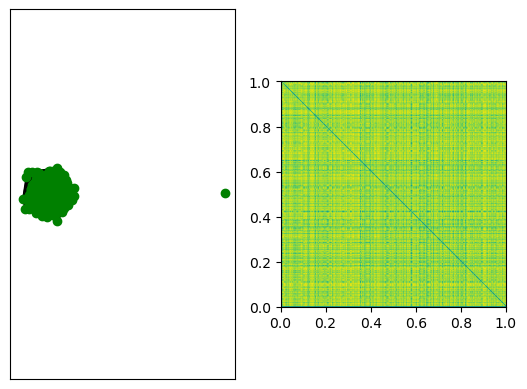

------------or and and: a common problem-----------


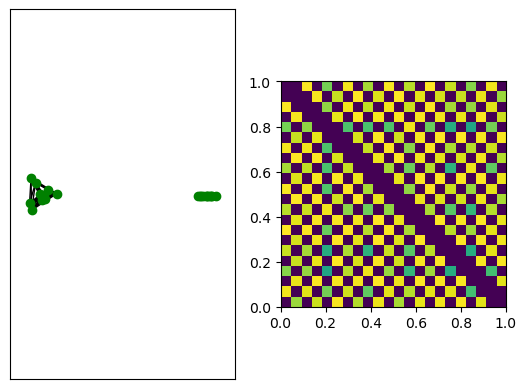

In [13]:
delta_list=[5]
for val in delta_list:
    for fn in [worst_case_blob]:
        print('------------and: a special problem-----------')
        X,Y=fn(num_samples=600,delta=val)
        W=build_similarity_graph(X,var=1.0,k=598,method='and')
        plot_graph_matrix(X,Y,W)
        
        print('------------or and and: a common problem-----------')
        X,Y=fn(num_samples=2,delta=val)
        for it in range(10):
            X_new,Y_new=fn(num_samples=2,delta=val)
            X=np.concatenate((X,X_new))
            Y=np.concatenate((Y,Y_new))
        W=build_similarity_graph(X,var=1.0,k=10,method='or')
        plot_graph_matrix(X,Y,W)

We highlight that if we have more than one connected component and this number is the same as the number of clusters that we want to create, it is a good option. Otherwise, if we are interested in a different number of clusters, we need to have only an unique connected component, _ie_ a connected graph. In relation with this, as we have shown in the question 1.2 using an epsilon graph might not be a good option.

An alternative approach is to build a K-NN graph. For this, we highlight that two methods need to be considered to build the undirected graph: "and" and "or". For the first one, a problem is that for some cases, as it is illustrated, we have that we need to build the fully conected graph to obtain a connected graph. Moreover, a commom problem for both methods is that if we have two groups, it might connect all the elements of the smaller group before adding an edge between a node of each of the connected components. Finally, we want to highlight that this problem is illustrated for two connected components, but it can be extended to an arbitrary number of connnected components.

In order to mention some bounds for both cases we have that for the method "or" we can guarantee the connectivity for $K \geq \lfloor \frac{|V|}{2} \rfloor $ (if $K < \lfloor \frac{|V|}{2} \rfloor$ we can have as counter-example the common problem for or and and shown before and if  $K \geq \lfloor \frac{|V|}{2} \rfloor $ two nodes have to share an edge or be neighbors of the same node).  Although, for the "and" method, as shown before, the bound founded is $K=n-1$.

However, for some cases the use of a K-NN graph with the method "or" might be a better solution than the epsilon-graph. For instance, if we have only an unique outlier very far from the other nodes like the case obtained with the function _worst_case_blob_ and delta=5.

### Q2.1: Build a graph starting from the data generated in `blobs`, and keep the graph connected. Use `spectral_clustering` to cluster the data. Motivate your choice on which eigenvectors to use and how you computed the clustering assignments from the eigenvectors. Now compute a similar clustering using the built-in k-means and compare the results.

In [14]:
def plot_eigenvalues(L,number_plot=10):
    """
    Function to plot the value of the eigenvalues to apply the elbow rule.
    Parameters
    ----------
    L: laplacian
    number_plot: number of eigenvalues to plot
        
    """
    import scipy as sp
    
    
    eig_val,eig_vec_right=sp.linalg.eig(L)
    eig_val_idx=list(np.argsort(eig_val))
    eig_val=eig_val.real
    
    U=eig_vec_right[:,eig_val_idx].real

    plt.figure()
    plt.plot(eig_val[eig_val_idx[:number_plot]],marker = 'o')
    plt.xticks([i for i in range(number_plot)])
    plt.title("Eigenvalues")
    plt.show()
    
    nb_row=2
    nb_col=3
    figure = plt.figure(figsize=(nb_col*6, nb_row*6))
    total=0
    for i in range(nb_row):
        for k in range(nb_col):
            plt.subplot(nb_row+1, nb_col, (k+1)+i*nb_col)
            plt.plot(U[:,total])
            plt.title(f"Eigenvector: {total+1}")
            total+=1
    plt.show()

def connected_similarity_graph(X,var=1.0,k=0,method='or'):
    """
    Computes the similarity matrix for a given dataset of samples keeping the graph connected. 
    If k=0, builds epsilon graph. 
    Otherwise, builds kNN graph.

    Parameters
    ----------
    X : numpy array
        (n x m) matrix of m-dimensional samples
    var : double 
        the sigma value for the exponential function, already squared
    k : int
        If zero, use epsilon-graph. Otherwise, use k-NN graph
        
    method: method to build the undirected graph on the k-NN graph
             'and':  and, both edges in the directed k-NN
             'or': or, at least one edge in the directed k-NN

    Returns
    -------
        W: (n x n) dimensional matrix representing the weight matrix of the graph
    """
    if k==0:
        W=build_similarity_graph(X,var=var,eps=0.0,k=0)
        T=min_span_tree(-W)
        min_eps=np.min(W[T>0])
        W_new=build_similarity_graph(X,var=var,eps=min_eps,k=0)
    else:
        if method=='and':
            W_new=build_similarity_graph(X,var=var,k=X.shape[0]-1,method='and')
        else:
            k_val=int(X.shape[0]/2)
            W_new=build_similarity_graph(X,var=var,k=k_val,method='or')
    return W_new

-------Comparison considering k-nn graph-------


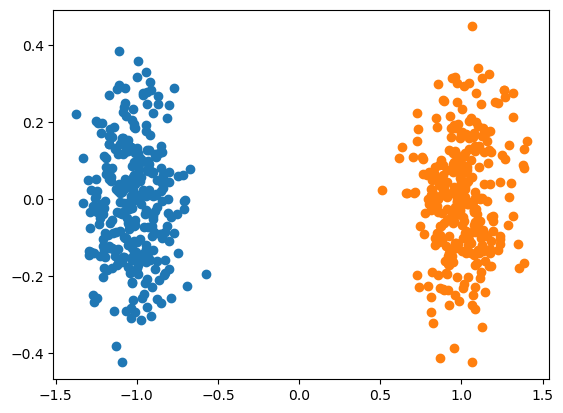

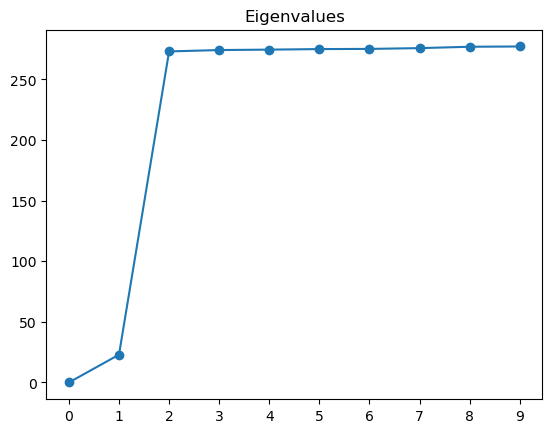

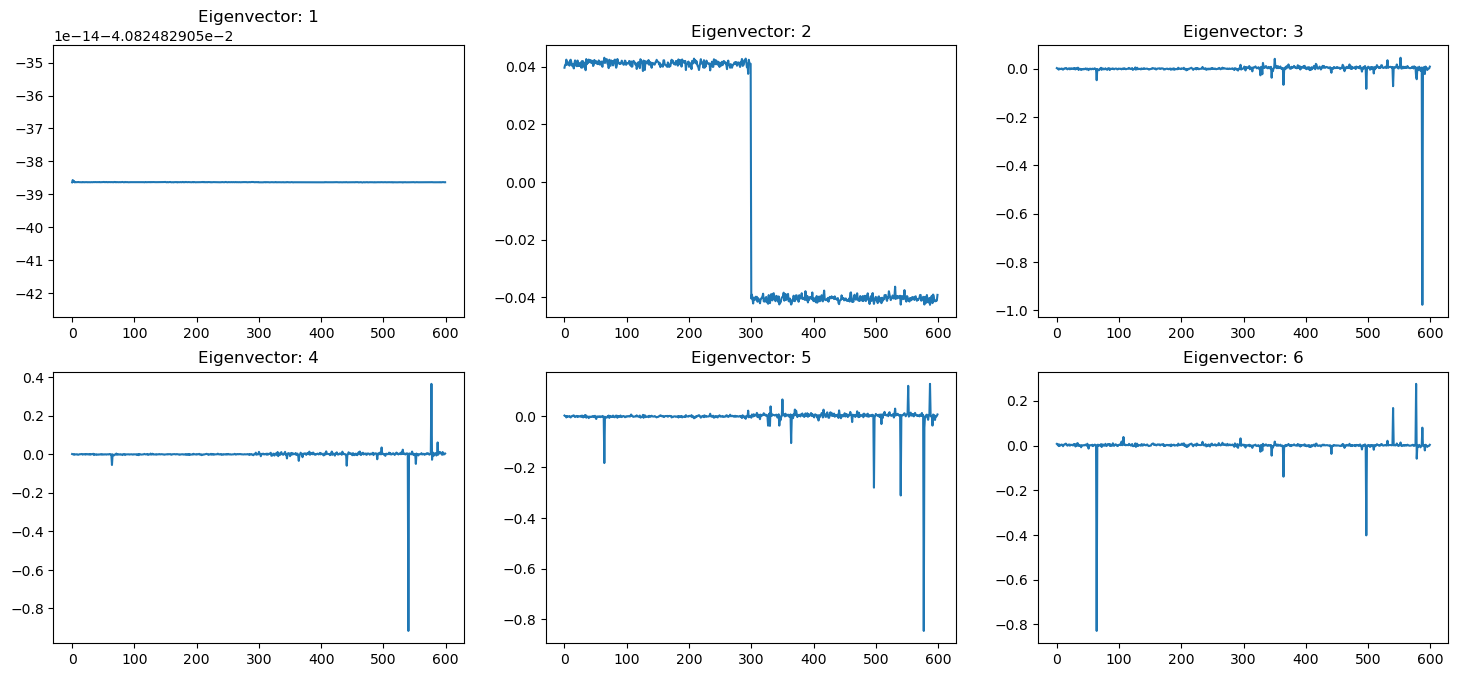

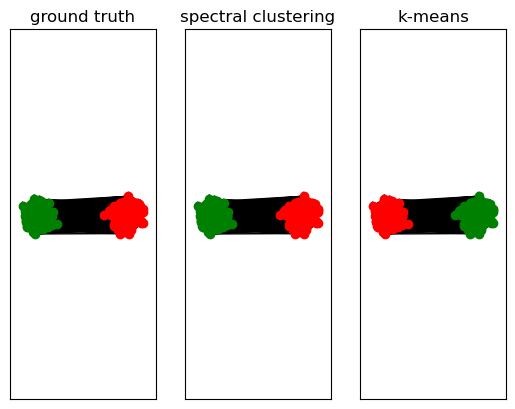

In [15]:
num_samples=600
X, Y = blobs(num_samples=num_samples)
plot_clusters(X, Y)

        
num_classes = 2

print('-------Comparison considering k-nn graph-------')
#W_new=connected_similarity_graph(X,var=1.0,k=int(num_samples*0.7))
W_new= build_similarity_graph(X, var=1.0, eps=0.0, k=int(num_samples*0.6),method='or')
L = build_laplacian(W_new)
plot_eigenvalues(L)

Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

# Plot results, comparing to KMeans
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

In this case, we use a connected graph with more edges than the needed to better ilustrate the difference between the multiplicity of zero and the next eigenvalue. In this, case, as the graph is connected the multiplicity of the eigenvalue zero is one. We foucs on the eigenvector corresponding to the smallest strictly positive eigenvalue, taking into accounnt Rayleigh-Ritz theorem. In this case, it thresholds the cluster in two components. Hence, we use it (we remark that in this case as we consider only one eigenvector that it is equivalent to apply a k-means).

Generally, spectral clustering is based on connectivity and $k$-means is based on compactness. In this case we obtain the same result for both methods as both clusters are easily separable. However, for cases as this might be more interesting to use $k$-means since a wrong graph construction (using a bad epsilon or a bad $k$ in $k$-NN) can lead to a wrong clustering

### Q2.2: Build a graph starting from the data generated in `blobs`, but this time make it so that the two components are separated. How do you choose which eigenvectors to use in this case? Motivate your answer.

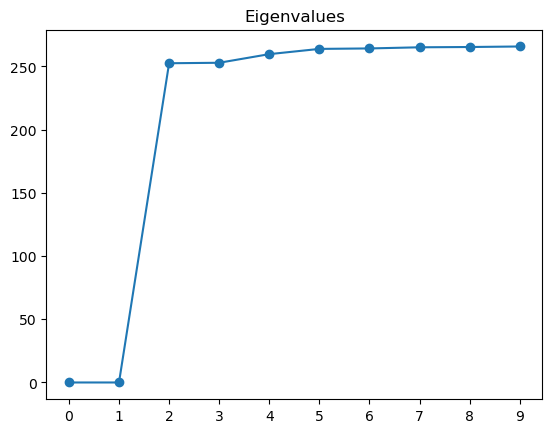

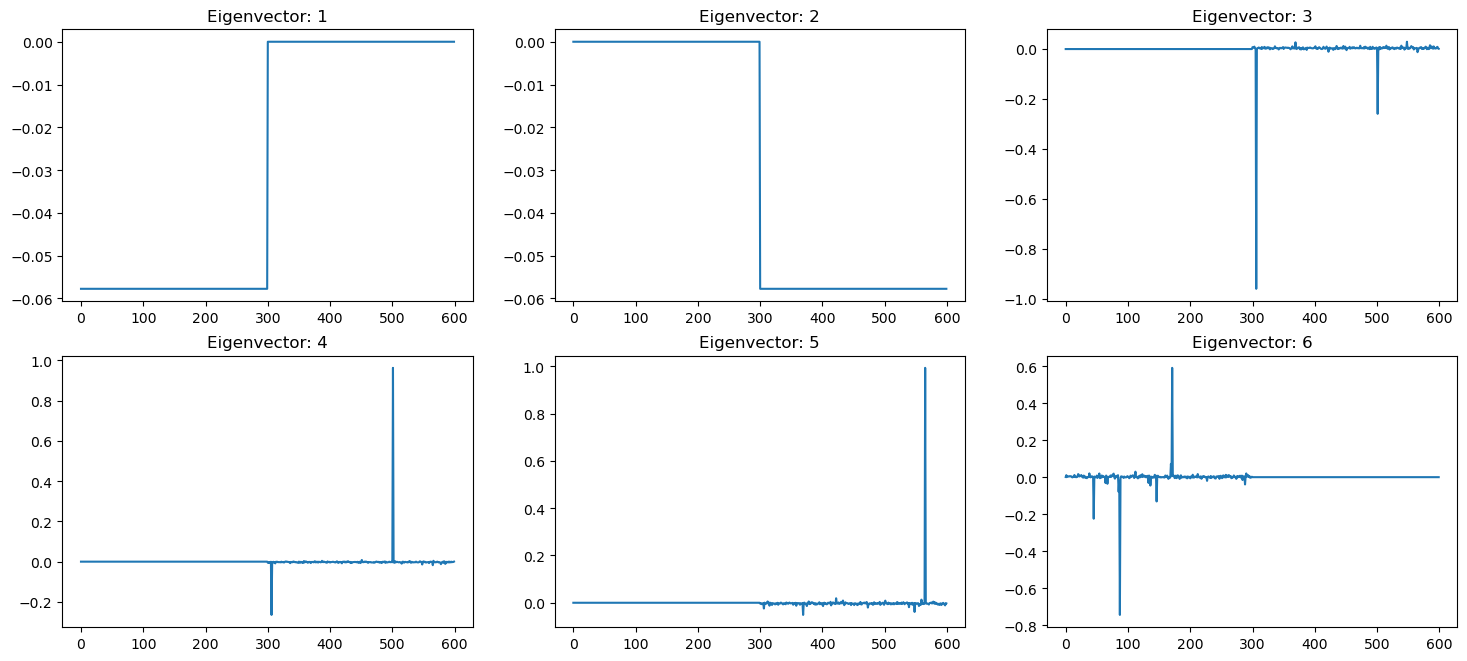

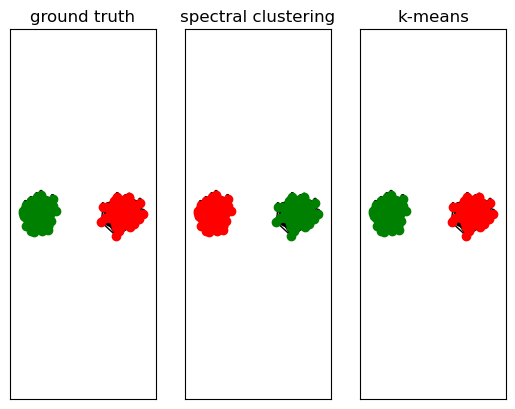

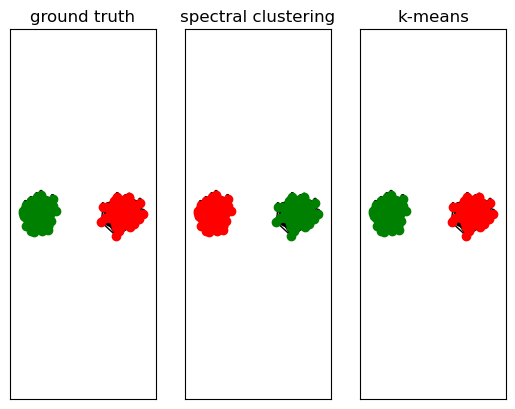

In [16]:
X, Y = blobs(num_samples=600)
W=build_similarity_graph(X,var=1.0,eps=0.0,k=0)
T=min_span_tree(-W)
min_eps=np.min(W[T>0])
W_new=build_similarity_graph(X,var=1.0,eps=min_eps+1e-4,k=0)
        
num_classes = 2
L = build_laplacian(W_new)
plot_eigenvalues(L)

Y_rec = spectral_clustering(L, chosen_eig_indices=[0], num_classes=num_classes)

plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

Y_rec = spectral_clustering(L, chosen_eig_indices=[1], num_classes=num_classes)

plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

In this, case, to garantee that the graph is not connected we use the $\epsilon$-graph with a $\epsilon$ bigger than the maximum that keeps it connected. As the graph has two connected components the multiplicity of the eigenvalue zero is two. Here, as we can see in the plot we can do a threshold to the first eigenvector or to the second and obtain a perfect clustering.

### Q2.3: In the function spectral_clustering, implement an automatic strategy to choose the eigenvectors to use for clustering, when chosen_eig_indices=None. Explain your strategy. Generate a dataset with 4 blobs and test your function. What happens when the variance of the blobs increase?

---- Variance in blows =  0.15 and k = 100
Clustering score =  1.0
  Spectral clustering results, comparing to KMeans:


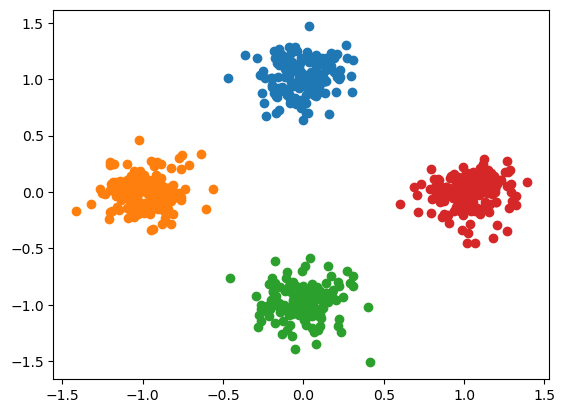

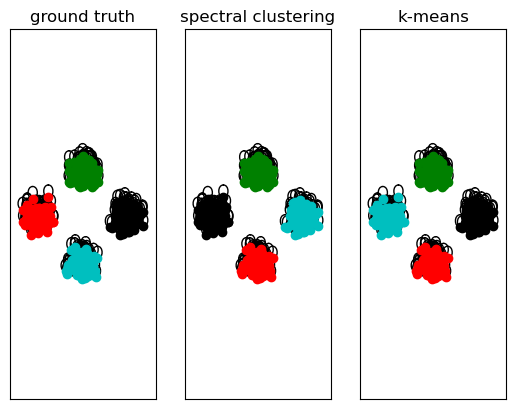

---- Variance in blows =  0.3 and k = 100
Clustering score =  0.874
  Spectral clustering results, comparing to KMeans:


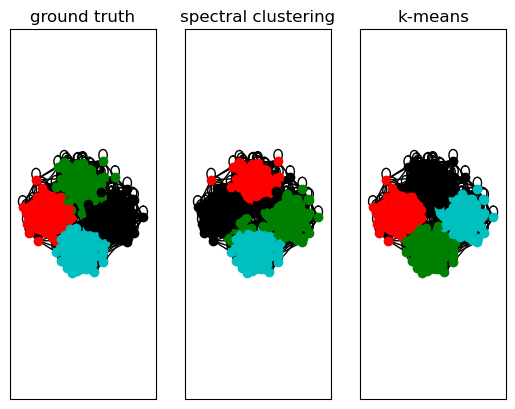

---- Variance in blows =  0.44999999999999996 and k = 100
Clustering score =  0.413
  Spectral clustering results, comparing to KMeans:


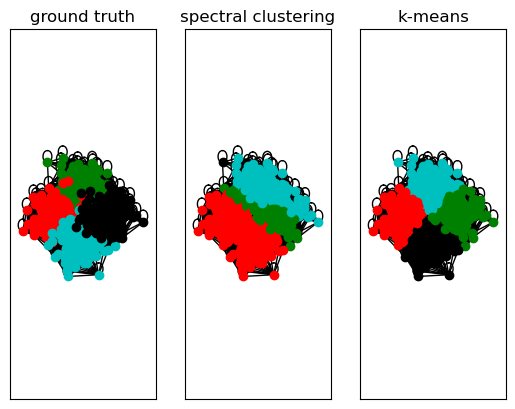

---- Variance in blows =  0.6 and k = 100
Clustering score =  0.243
  Spectral clustering results, comparing to KMeans:


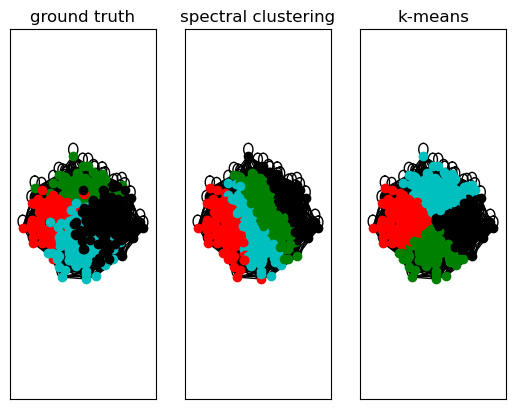

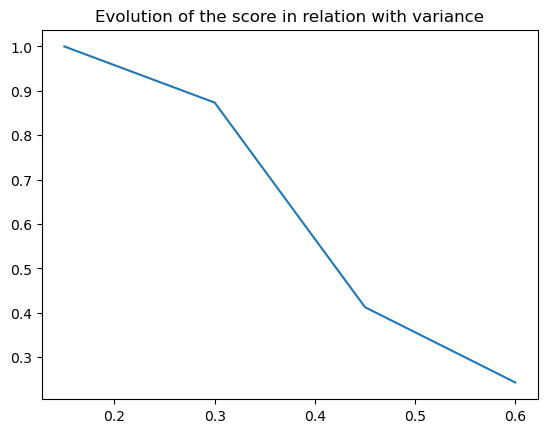

In [17]:
X, Y = blobs(num_samples=600, n_blobs=4, blob_var=0.15)
plot_clusters(X, Y)

variance=[0.15*i for i in range(1,5)]

score_list=[]

for var in variance:
    print('---- Variance in blows = ', var , 'and k = 100')
    
    X, Y = blobs(num_samples=600, n_blobs=4, blob_var=var)
    W = build_similarity_graph(X, k=100)
    L = build_laplacian(W)
    Y_rec = spectral_clustering(L,chosen_eig_indices=None,num_classes=4)
    
    aux=skm.adjusted_rand_score(Y, Y_rec)
    score_list.append(aux)
    print('Clustering score = ' , np.round(aux,3))
    print('  Spectral clustering results, comparing to KMeans:')
    plot_clustering_result(X, Y, L, Y_rec, KMeans(4).fit_predict(X))
    plt.show()

plt.figure()
plt.plot(variance,score_list)
plt.title('Evolution of the score in relation with variance')
plt.show()

The automatic strategy consists in considering the eigenvectors corresponding to small eigenvalues, except the first eigenvector. Then, we consider only the ones corresponding to the smaller eigenvalues until the sum of then reachs a fixed parameter.


Here, we can see that increasing the variance imply that the four clusters are connected. For this case, as spectral clustering is based on connectivity it gives poor results. However, as $k$-means is based on compactness it keeps producing good results.

### Q2.4: When you built the cluster assignment, did you use thresholding, k-means or both? Do you have any opinion on when to use each?

Generally, a $k$-means is better if we have more than two clusters as it is better to capture the different clusters. However, for the examples of the previous questions, we consider a threshold as we have only two clusters and they can be easily obteined considering the first or second eigenvector. We remark that by considering only one eigenvector we are doing a threshold.

### Q2.5: Generate `two_moons` data and compare spectral clustering to k-means. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

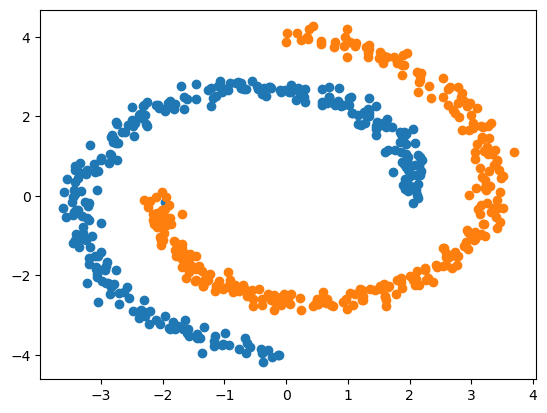

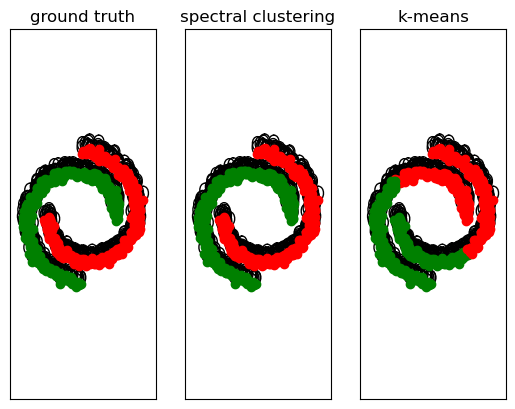

In [18]:
X, Y = two_moons(num_samples=600)
plot_clusters(X, Y)

W=build_similarity_graph(X,var=1.0,eps=0.0,k=0)
T=min_span_tree(-W)
min_eps=np.min(W[T>0])
W_new=build_similarity_graph(X,var=1.0,eps=min_eps,k=0)
num_classes = 2
L = build_laplacian(W_new)
Y_rec= spectral_clustering(L,chosen_eig_indices=[1,2],num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

### Q2.6: Generate `point_and_circle` data and compare spectral clustering using the normal Laplacian and the random-walk regularized Laplacian. Do you notice any difference? Taking into consideration the graph structure, can you explain them?

----normal Laplacian--------


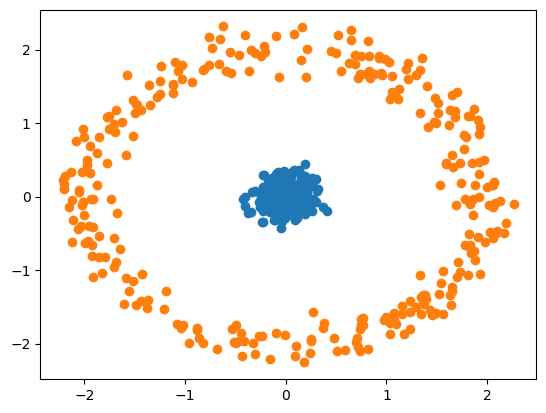

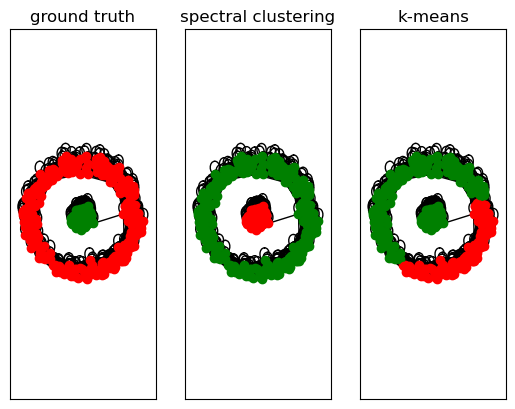

----random-walk regularized Laplacian--------


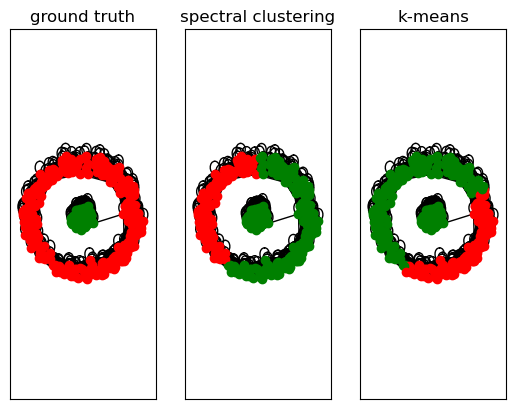

In [19]:
#point_and_circle?
X, Y = point_and_circle(num_samples=600)
plot_clusters(X, Y)

W=build_similarity_graph(X,var=1.0,eps=0.0,k=0)
T=min_span_tree(-W)
min_eps=np.min(W[T>0])
W_new=build_similarity_graph(X,var=1.0,eps=min_eps,k=0)
num_classes = 2

print('----normal Laplacian--------')
L = build_laplacian(W_new)
Y_rec= spectral_clustering(L,chosen_eig_indices=[1,2],num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))
print('----random-walk regularized Laplacian--------')
L = build_laplacian(W_new,laplacian_normalization='rw')
Y_rec= spectral_clustering(L,chosen_eig_indices=[1,2],num_classes=num_classes)
plot_clustering_result(X, Y, L, Y_rec, KMeans(num_classes).fit_predict(X))

For this graph characteristics we obtain a good result for the unnormalized but a bad result for the random-walk regularized laplacian. Hence, the used Laplacian is important in relation to obtain a good clustering. This might be explained as the unnormalized is based on the RatioCut, trying to maximize the cardinal of each cluster, and the random walk regularization is based on solving the NCut problem, trying to maximize the volume of each cluster.

### Q2.7: Using the function parameter_sensitivity, comment on the stability of spectral clustering when varying $\epsilon$ or k. 

----for epsilon-----


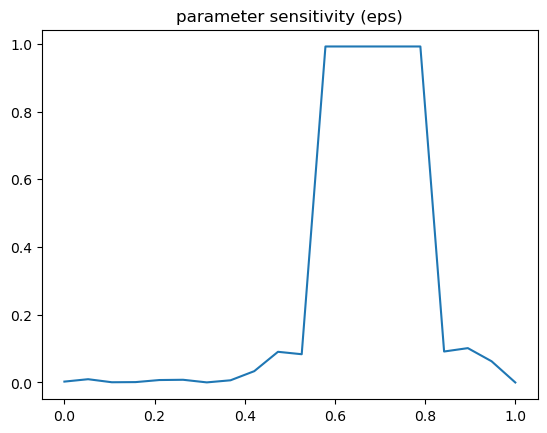

----for k-NN-----


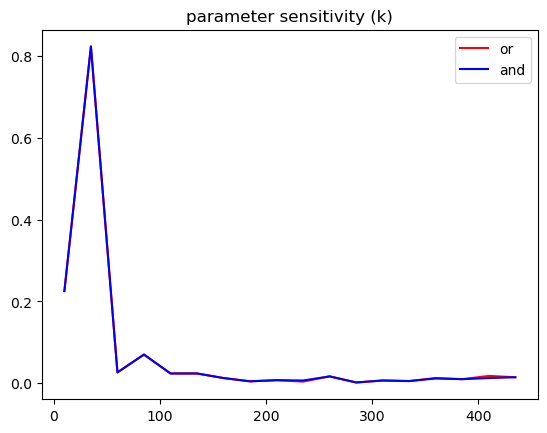

In [20]:
print('----for epsilon-----')
parameter_sensitivity(parameter_type='eps')
print('----for k-NN-----')
parameter_sensitivity(parameter_type='k')

We use 600 samples of two_moons, and contruct similarity graph . He used different 20 values of 
In order to analyze the sensitivity to the parameters of spectral clustering we test with the _two_moons_ functions different values for $\epsilon$ and for $k$ in the graph construction. In both type of graphs, we can see that the score is extremely sensitive to the hyperparameter value as a small change in the value of the parameter can produce extremely changes on the score. For instance, a bad choice of the hyperparameter gives scores of almost zero. However, a good choice of it can give almost perfect scores.

### Q2.8: If we did not have access to "true" labels, how could we evaluate the clustering result (or what should we not use as evaluation)?

We remark that we cannot use measures like intra-class or inter-class inertia as it is not good for data generated with functions like _two\_moons_ or _point_and_circle_. Instead, we can use measures like modularity.
Modularity is a measure with values between -0.5 and 1, with higher values indicating a better division of the graph into clusters.

An alternative is to use the silhouette score, which has values between -1 and 1. It is calculated as the average of the score for each node to produce the overall silhouette score. For this score, the higher value for each sample the bigger is the similarity with other elements of the same cluster. 

### Q3.1: Complete all the code necessary, and cluster the `four_elements` and `fruit_salad` images in the data folder and include here some images of the clustering.  Explain your design choices in the overall pipeline (e.g. which graph, which pre-processing...) and how you think they impact the results you are seeing. Report also at least one failure mode for the algorithm.

----failure mode----
Wrong number of classes:


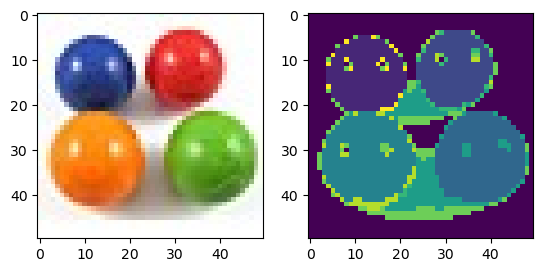

Wrong value of k:


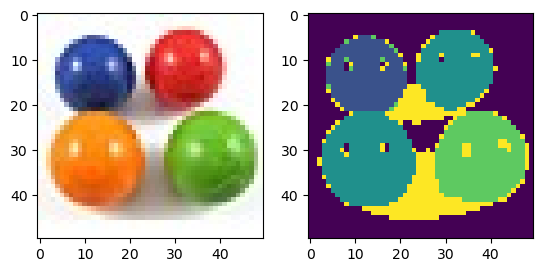

----good results----


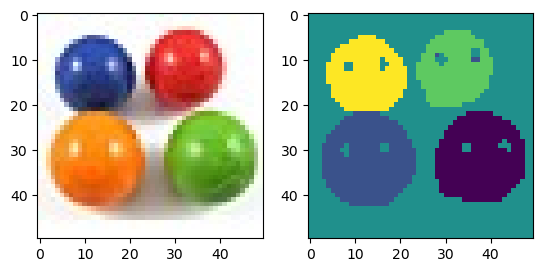

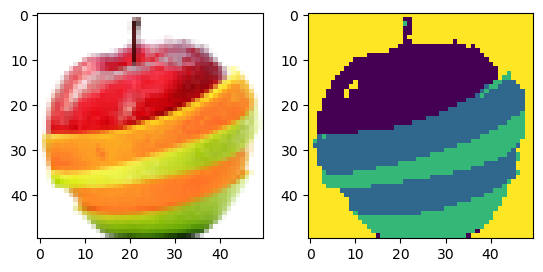

In [21]:
print('----failure mode----')
print('Wrong number of classes:')
image_segmentation(input_img='four_elements.bmp',k=40,eps=eps_val,num_classes=10,chosen_eig_indices=None)
print('Wrong value of k:')
image_segmentation(input_img='four_elements.bmp',k=80,eps=eps_val,num_classes=5,chosen_eig_indices=None)

print('----good results----')
image_segmentation(input_img='four_elements.bmp',k=40,num_classes=5,chosen_eig_indices=None)
    
image_segmentation(input_img='fruit_salad.bmp',k=25,num_classes=4,chosen_eig_indices=None)
 

We decide to use a $k$-NN graph with the "or" method as it might capture better the relations between two nodes, as the class might have a very different number of nodes and of different types. Also, we used the unnormalized Laplacian as it gave better results than the random walk. The $k$ value was hand-crafted.

As it can be seen in the failure cases, if we select a wrong value for the number of classes we can obtain different groups for the same background, for instace. So, we select the number of classes manually as the classes that we can distinguish. In the same way, a wrong value of $k$ imply that two classes will be the same, like the orange and red objects.

### Q3.2: A full graph built between the pixels of a 50 × 50 image corresponds to $50^2$ nodes. Solving the full eigenvalue problem in this case would scale in the order of $2^{34}$ . Even on weak hardware this takes only seconds to minutes. Segmenting a Full HD picture of 1920 × 1080 would scale in the order of $2^{64}$ (about a month on a decent machine). Beyond that, the large picture would require to store in memory a graph over millions of nodes. A full graph on that scale requires about 1TB of memory. Can you think two simple techniques to reduce the computational and occupational cost of Spectral Clustering?

We highlight that the main computational cost is related to the spectral clustering. So, an alternative is to reduce the number of original nodes. For this, we consider two different options.

**First option:** to use super-pixels, a way to combine pixels with similar characteristics. Then, each superpixel will represent an unique node.

**Second option:** to reduce the picture by downsampling it. Then, it will be upsampled and each pixel of the original image is assigned to a pixel in the downsampled image.

### Q3.3: Choose a larger image of your choice, and try to implement some of the scalability modifications to run spectral clustering on it. Report some examples of the results you achieve. 

In [22]:
from PIL import Image
import os

The used image is from Wikipedia and can be found in:

https://github.com/RD-RegueiroEspino/M2/tree/main/graphs-ML/data

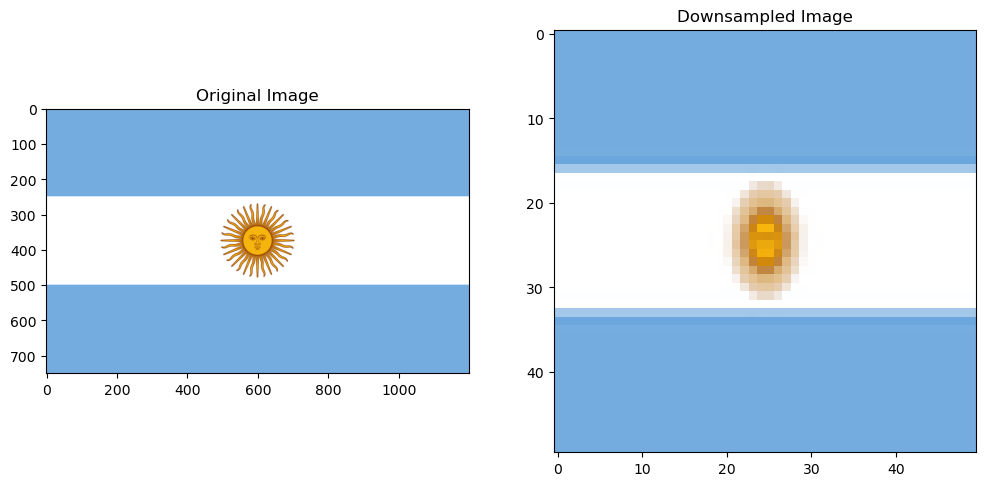

In [23]:
img = Image.open("data_new/argentina.bmp")


width,height=img.size
new_width=50
new_height=50
img_downsampled=img.resize((new_width,new_height),Image.ANTIALIAS)
fig,(ax1, ax2)=plt.subplots(1,2,figsize=(12, 6))
ax1.imshow(img)
ax1.set_title("Original Image")
ax2.imshow(img_downsampled)
ax2.set_title("Downsampled Image")
plt.show()

downsampled_image_path = os.path.join("downsampled_image.jpg")
img_downsampled.save('data/downsampled_image.jpg')

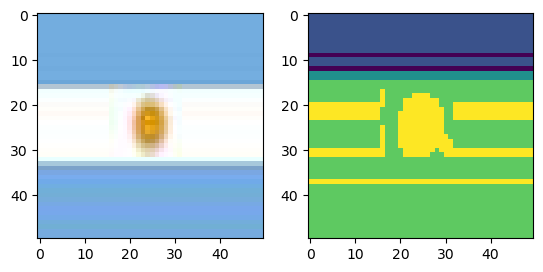

In [30]:
image_segmentation(input_img='downsampled_image.jpg',k=35,num_classes=5)

Here we can see that it might be a good option if a way to smooth the segmentation is included.